In [1]:
# ─────────────────────────────────────────────
# 0 : Loading
# ─────────────────────────────────────────────

%load_ext autoreload
%autoreload 2

In [2]:
# ─────────────────────────────────────────────
# 1.1 : Python Version
# ─────────────────────────────────────────────

import sys, site
print("Python:", sys.executable)
print("User site:", site.getusersitepackages())
print("Site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else "n/a")


# ─────────────────────────────────────────────
# 1.2 : Librairies
# ─────────────────────────────────────────────

import numpy as np
import polars as pl

from pathlib import Path
from matplotlib import pyplot as plt

from ncl.reading import getting_main_file_with_verifications

Python: /home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/bin/python
User site: /home/nicolas/.local/lib/python3.12/site-packages
Site-packages: ['/home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/lib/python3.12/site-packages', '/home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/local/lib/python3.12/dist-packages', '/home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/lib/python3/dist-packages', '/home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/lib/python3.12/dist-packages']


ModuleNotFoundError: No module named 'ncl'

In [3]:
# ─────────────────────────────────────────────
# 2.1 : Functions
# ─────────────────────────────────────────────

# Datas

def ordering_df(df: pl.DataFrame) -> pl.DataFrame:
    df_sorted = df.sort(
        by=["s", "alpha_choice", "bpmin", "l"] ,
        descending=[False, False, False, False]
    )
    return df_sorted

def data_one_scen(df: pl.DataFrame, scen: dict) -> pl.DataFrame:
    return df.filter(
        (pl.col("alpha_choice") == scen["alpha_choice"])
        & (pl.col("s") == scen["s"])
        & (pl.col("l") == scen["l"])
        & (pl.col("bpmin") == scen["bpmin"])
    )


# Cuts 

def cut_1_mu(df: pl.DataFrame, scen: dict, mu: int) -> pl.DataFrame:
    return df.filter(
        (pl.col("alpha_choice") == scen["alpha_choice"])
        & (pl.col("s") == scen["s"])
        & (pl.col("l") == scen["l"])
        & (pl.col("bpmin") == scen["bpmin"])
        & (pl.col("mu") == mu)
    )
    
def cut_1_theta(df: pl.DataFrame, scen: dict, theta: int) -> pl.DataFrame:
    return df.filter(
        (pl.col("alpha_choice") == scen["alpha_choice"])
        & (pl.col("s") == scen["s"])
        & (pl.col("l") == scen["l"])
        & (pl.col("bpmin") == scen["bpmin"])
        & (pl.col("theta") == theta)
    )
    
def cut_1_l(df: pl.DataFrame, scen: dict, mu: int,  theta: int) -> pl.DataFrame:
    return df.filter(
        (pl.col("alpha_choice") == scen["alpha_choice"])
        & (pl.col("s") == scen["s"])
        & (pl.col("bpmin") == scen["bpmin"])
        & (pl.col("mu") == mu)
        & (pl.col("theta") == theta)
    )


# ─────────────────────────────────────────────
# 2.2 : Getting datas
# ─────────────────────────────────────────────

# Root
root = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN"

# Reading 
path_datas = root / "ncl_output.parquet"
df_raw = pl.read_parquet(path_datas)

# Loading + Filtering
df_main = getting_main_file_with_verifications(df_raw)

# Ordering
df_data = ordering_df(df_main)


# ─────────────────────────────────────────────
# 2.3 : Reading Scenarios
# ─────────────────────────────────────────────

# Reading
path_scenario = root / "scenarios.json"
all_scenarios = pl.read_json(path_scenario)

# Ordering
df_scenarios = ordering_df(all_scenarios)


# ─────────────────────────────────────────────
# 2.4 : Prints
# ─────────────────────────────────────────────

# print("All scenarios:\n", df_scen)

df_scen_nucleo = df_scenarios[0, 2, 12]
print("Nucleo scenarios:\n", df_scen_nucleo)

df_scen_linker = df_scenarios[1:9]
print("Linker scenarios:\n", df_scen_linker)

df_scen_bpmin = df_scenarios[9:12]
print("Bpmin scenarios:\n", df_scen_bpmin)

df_scen_work = df_scenarios[0, 2, 9, 10, 11]
print("Work scenarios:\n", df_scen_bpmin)

FileNotFoundError: No such file or directory (os error 2): /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-01-01_PSMN/ncl_output.parquet

In [4]:
# ─────────────────────────────────────────────
# 3.0 : Cuts Of Hetmaps - (µ,θ) Values
# ─────────────────────────────────────────────

df_scen = df_scen_linker
mu      = 180
theta   = 90


# ─────────────────────────────────────────────
# 3.1 : Plot - One Proba (µ,θ) - Every Scenario
# ─────────────────────────────────────────────

plt.figure(figsize=(8,6))
plt.title(f"mu={mu} - theta={theta}")

for scen in df_scen.iter_rows(named=True):
    
    # DataFrame
    df = data_one_scen(df_data, scen)
    df_proba = df.filter((pl.col("mu") == mu) & (pl.col("theta") == theta))
    
    # Scenario parameters
    alpha_choice = df_proba["alpha_choice"].to_numpy()[0]
    s = df_proba["s"].to_numpy()[0]
    l = df_proba["l"].to_numpy()[0]
    bpmin = df_proba["bpmin"].to_numpy()[0]
    
    # Data
    vi_med = df_proba["vi_med"].to_numpy()[0]
    plt.scatter(l, vi_med, label=f"{alpha_choice} - s={s} - l={l} - bpmin={bpmin}")

# Plot
plt.xlabel("linker size l")
plt.ylabel("vi_med")
plt.legend()
plt.grid(True)
plt.show()


# ─────────────────────────────────────────────
# 3.2 : Plot - Few Probas via 1θ - Few Scenario
# ─────────────────────────────────────────────

plt.figure(figsize=(8,6))
plt.title(f"theta={theta}")

for scen in df_scen.iter_rows(named=True):
    
    # DataFrame
    df_1_theta = cut_1_theta(df_data, scen, theta)
    df_1_theta_sorted = df_1_theta.sort(
            by="mu" , descending=False
    )
    
    # Scenario parameters
    alpha_choice = df_1_theta_sorted["alpha_choice"].to_numpy()[0]
    s = df_1_theta_sorted["s"].to_numpy()[0]
    l = df_1_theta_sorted["l"].to_numpy()[0]
    bpmin = df_1_theta_sorted["bpmin"].to_numpy()[0]
    
    # Data
    vi_med = df_1_theta_sorted["vi_med"].to_numpy()[0]
    plt.plot(
        df_1_theta_sorted["mu"], df_1_theta_sorted["vi_med"],
        label=f"{alpha_choice} - s={s} - l={l} - bpmin={bpmin}",
        marker="o", lw=0.75, alpha=0.75
    )

# Plot
plt.xlabel("mu")
plt.ylabel("vi_med")
plt.legend()
plt.grid(True)
plt.show()


# ─────────────────────────────────────────────
# 3.3 : Plot - Few Probas via 1µ - Few Scenario
# ─────────────────────────────────────────────

plt.figure(figsize=(8,6))
plt.title(f"mu={mu}")

for scen in df_scen.iter_rows(named=True):
    
    # DataFrame
    df_1_mu = cut_1_mu(df_data, scen, mu)
    df_1_mu_sorted = df_1_mu.sort(
            by="theta" , descending=False
    )
    
    # Scenario parameters
    alpha_choice = df_1_mu_sorted["alpha_choice"].to_numpy()[0]
    s = df_1_mu_sorted["s"].to_numpy()[0]
    l = df_1_mu_sorted["l"].to_numpy()[0]
    bpmin = df_1_mu_sorted["bpmin"].to_numpy()[0]
    
    # Data
    vi_med = df_1_mu_sorted["vi_med"].to_numpy()[0]
    plt.plot(
        df_1_mu_sorted["theta"], df_1_mu_sorted["vi_med"],
        label=f"{alpha_choice} - s={s} - l={l} - bpmin={bpmin}",
        marker="o", lw=0.75, alpha=0.75
    )
    
# Plot
plt.xlabel("theta")
plt.ylabel("vi_med")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'df_scen_linker' is not defined

/tmp/ipykernel_1687604/4025436227.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(mu_values))(range(len(mu_values)))


NameError: name 'df_data' is not defined

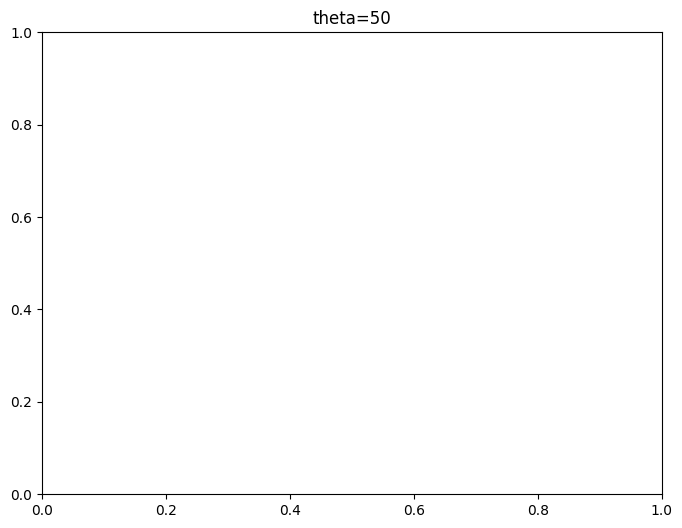

In [5]:
# ─────────────────────────────────────────────
# 4.1 : Focused On Linker Size : θ fixed.
# ─────────────────────────────────────────────

mu_values = np.arange(100,501,100)
theta = 50
colors = plt.cm.get_cmap('viridis', len(mu_values))(range(len(mu_values)))

plt.figure(figsize=(8,6))
plt.title(f"theta={theta}")


for (mu, c) in zip(mu_values, colors):
    df = cut_1_l(df_data, df_scen_linker[0], mu, theta)
    s = df_1_mu_sorted["s"].to_numpy()[0]
    l_vals = np.asarray(df["l"].to_numpy(), dtype=float)
    vi_th = mu * (l_vals / (l_vals + s))
    plt.plot(df["l"], df["vi_med"], marker="o", label=f"mu = {mu}", c=c)
    plt.plot(df["l"], vi_th, marker="o", ls="--", label=f"mu = {mu}", c=c)

# Plot
plt.xlabel("l")
plt.ylabel("vi_med")
plt.legend(title="mus", ncol=2)
plt.grid(True)
plt.show()


# ─────────────────────────────────────────────
# 4.2 : Focused On Linker Size : µ fixed.
# ─────────────────────────────────────────────

mu = 300
theta_values = np.arange(10,81, 20)
colors = plt.cm.get_cmap('viridis', len(theta_values))(range(len(theta_values)))

plt.figure(figsize=(8,6))
plt.title(f"mu={mu}")

for (theta, c) in zip(theta_values, colors):
    df = cut_1_l(df_data, df_scen_linker[0], mu, theta)
    s = df_1_mu_sorted["s"].to_numpy()[0]
    l_vals = np.asarray(df["l"].to_numpy(), dtype=float)
    vi_th = mu * (l_vals / (l_vals + s))
    plt.plot(df["l"], df["vi_med"], marker="o", label=f"theta = {theta}", c=c)
    plt.plot(df["l"], vi_th, marker="o", ls="--", label=f"theta = {theta}", c=c)

# Plot
plt.xlabel("l")
plt.ylabel("vi_med")
plt.legend(title="thetas", ncol=2)
plt.grid(True)
plt.show()

# TESTS

Courbe de valeur maximale de (vi_med / mu) en fonction du point le plus chaud en suivant les configs en fait

Donc c'est extraire le point maximal pour chaque config 

Puis tracer ce point maximal en fonction de la config et donc de la taille du linker

Attention perte de periodicité au fur et à mesure

Necessite une detection automatique du point le plus chaud : récupérer son mu_value

In [74]:
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import os


plt.rcParams['font.size'] = 16


def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

working_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "ncl_test_0"
os.chdir(working_path)

df_work = pl.DataFrame()
df_work = pl.concat([pl.read_parquet(file) for file in working_path.rglob("*.parquet") if file.is_file()])
# print(df_work)

all_peaks = []


plt.figure(figsize=(8,6))
for row in df_work.iter_rows(named=True):

    # Extracting datas
    l = row["l"]
    s = row["s"]
    alphaf = row["alphaf"]
    alphao = row["alphao"]
    link_view = row["link_view"]
    label = f"l={row['l']}"
    norm = (s * alphao + alphaf * l) / (s + l)
    data = np.divide(link_view, norm)

    # Calculating sinusoid factors
    x = np.arange(0, len(data), 1)
    popt, _ = curve_fit(sinusoid, x, data)
    A_fit, omega_fit, phi_fit = popt

    # Getting the local maximas
    peaks, _ = find_peaks(data, distance=100)
    all_peaks.append(peaks)
    
    # Plotting
    plt.plot(data, label=f"{label} : y = {A_fit:.2f} sin({omega_fit:.2f} x + {phi_fit:.2f})")
    plt.scatter(peaks, data[peaks], color="red", marker="x")

    
plt.xlim([0, 3000])
plt.ylim([0, 10])
plt.xlabel("position in bp")
plt.ylabel("phase count")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
for i in range(0, len(all_peaks)):
    plt.plot(np.arange(0,10), all_peaks[i][0:10], label=f"{i}", marker="o")
plt.xlabel("peak count")
plt.ylabel("peak position")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/ncl_test_0'

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import polars as pl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Définir le modèle sinusoidal
def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

# Chargement des données
working_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "ncl_test_0"
os.chdir(working_path)
df_work = pl.concat([pl.read_parquet(file) for file in working_path.rglob("*.parquet") if file.is_file()])

all_peaks = []

# Création de la figure principale
fig, ax = plt.subplots(figsize=(8,6))  # 🔧 Figure + Axes

for row in df_work.iter_rows(named=True):

    l = row["l"]
    s = row["s"]
    alphaf = row["alphaf"]
    alphao = row["alphao"]
    link_view = row["link_view"]
    label = f"l={l}"
    norm = (s * alphao + alphaf * l) / (s + l)
    data = np.divide(link_view, norm)

    x = np.arange(0, len(data), 1)
    popt, _ = curve_fit(sinusoid, x, data)
    A_fit, omega_fit, phi_fit = popt

    peaks, _ = find_peaks(data, distance=100)
    all_peaks.append(peaks)
    
    ax.plot(data, label=f"{label} : y = {A_fit:.2f} sin({omega_fit:.2f} x + {phi_fit:.2f})")
    # ax.scatter(peaks, data[peaks], color="red", marker="x")

# Légendes principales
ax.set_xlim([0, 3000])
ax.set_ylim([0, 10])
ax.set_xlabel("position in bp")
ax.set_ylabel("phase count")
ax.legend(loc="upper left", fontsize=8)

# 🔍 Inset plot : zoom sur un pic
ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper right", borderpad=2)

# Exemple : zoomer sur la première courbe si elle existe
if len(all_peaks) > 0:
    for i in range(0, len(all_peaks)):
        ax_inset.plot(np.arange(0,10), all_peaks[i][0:10], label=f"{i}", marker="o")
        ax_inset.set_xlabel("peak count")
        ax_inset.set_ylabel("peak position")
        # ax_inset.set_xticks([])
        # ax_inset.set_yticks([])
        ax_inset.legend(fontsize=8)

# plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/ncl_test_0'

# .